In [1]:
#copying and adapting code from https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=YyQtV7155Nht

In [21]:
#apply to 2D example
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns
import pandas as pd
import math

# Define model

In [2]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [3]:
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()

        self.marginal_prob_std = marginal_prob_std
        self.hidden_units = 64
        # inputs of data (x,y), timestep t
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=self.hidden_units), 
                                   nn.Linear(self.hidden_units, self.hidden_units))
        

        self.l1 = nn.Linear(2, self.hidden_units, bias=True)
        self.emb1 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l2 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb2 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l3 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb3 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l4 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb4 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l5 = nn.Linear(self.hidden_units, 2, bias=True)
        self.act=nn.GELU()
    def forward(self, x):
        t = x[:, 2]

        e = self.act(self.embed(t))    
        x = x[:,[0,1]]
        
        h1 = self.l1(x)
        h1+=self.emb1(e)
        h1 = self.act(h1)
        
        h2 = self.l2(h1)
        h2+=self.emb2(e)
        h2 = self.act(h2)
        
        h3 = self.l3(h2)
        h3+=self.emb3(e)
        h3 = self.act(h3)
        
        h4 = self.l4(h3)
        h4+=self.emb4(e)
        h4 = self.act(h4)
        
        h5 = self.l5(h4)
        
        h5 = h5 / self.marginal_prob_std(t)[:, None]
        return h5

In [103]:
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()
        self.act = nn.GELU()#lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.hidden_units = 256
        # inputs of data (x,y), timestep t
        self.mlp = nn.Sequential(
            nn.Linear(3, int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/16), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/16), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), 2, bias=True)
        )
    
    def forward(self, x):
        t = x[:, 2]
        x = self.mlp(x)
        x = x / self.marginal_prob_std(t)[:, None]
        return x

In [9]:
#Implimentation from shi et al - testing :)
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()
        self.marginal_prob_std = marginal_prob_std
        
        self.net = MLP(3 * 32,
                       layer_widths=[128,128] + [2],
                       activate_final = False,
                       activation_fn=torch.nn.LeakyReLU())

        self.t_encoder = MLP(16,
                             layer_widths=[16] + [32],
                             activate_final = True,
                             activation_fn=torch.nn.LeakyReLU())

        self.xy_encoder = MLP(2,
                              layer_widths=[32] + [64],
                              activate_final = True,
                              activation_fn=torch.nn.LeakyReLU())
        
    def forward(self, x):
        t = x[:, -1]
        norm = self.marginal_prob_std(t)[:, None]
        t = t.reshape(-1,1)
        xy = x[:,[0,1]]
        
        t_emb = get_timestep_embedding(t, 16, 10000)
        t_emb = self.t_encoder(t_emb)
        xy_emb = self.xy_encoder(xy)

        
        h = torch.cat([xy_emb, t_emb], -1)

        out = self.net(h) 

        out = out / norm
        return out

In [10]:
def get_timestep_embedding(timesteps, embedding_dim=128, max_period=10000):
    """
      From Fairseq.
      Build sinusoidal embeddings.
      This matches the implementation in tensor2tensor, but differs slightly
      from the description in Section 3.5 of "Attention Is All You Need".
      https://github.com/pytorch/fairseq/blob/master/fairseq/modules/sinusoidal_positional_embedding.py
    """
    half_dim = embedding_dim // 2
    emb = math.log(max_period) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)

    emb = timesteps * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, [0,1])

    return emb

In [11]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, layer_widths, activate_final = False, activation_fn=F.relu):
        super(MLP, self).__init__()
        layers = []
        prev_width = input_dim
        for layer_width in layer_widths:
            layers.append(torch.nn.Linear(prev_width, layer_width))
            # # same init for everyone
            # torch.nn.init.constant_(layers[-1].weight, 0)
            prev_width = layer_width
        self.input_dim = input_dim
        self.layer_widths = layer_widths
        self.layers = torch.nn.ModuleList(layers)
        self.activate_final = activate_final
        self.activation_fn = activation_fn
        
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation_fn(layer(x))
        x = self.layers[-1](x)
        if self.activate_final:
            x = self.activation_fn(x)
        return x

# Set up SDE

In [12]:
#@title Set up the SDE

device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)
  
sigma =  8.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

# Loss function

In [13]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device='cpu') * (1. - eps) + eps  
    std = marginal_prob_std(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None]
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

# Training

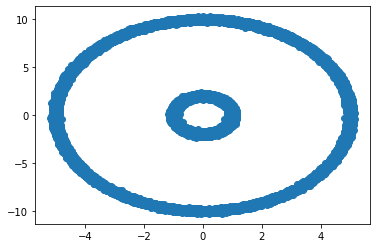

In [174]:
circles, _ = datasets.make_circles(1024*128, noise=0.01, factor=0.2, shuffle=True)
circles = circles* [5., 10.] 
circles = circles.T
plt.scatter(circles[0], circles[1])

In [176]:

epochs = 300
batch_size = 100
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = torch.tensor(circles).T
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        #print(x)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/300 [00:00<?, ?it/s]

<ipython-input-51-4fb5fc172600>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


In [ ]:
#TODO

#get conditioning started

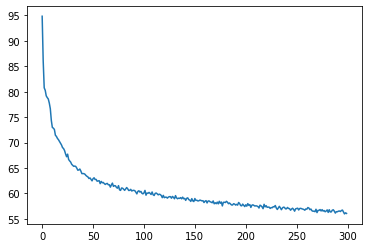

In [178]:
plt.plot(losses)

# Sampling with numerical SDE solver

In [14]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  1000#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=1000, 
                           num_steps=num_steps, 
                           device='cpu', 
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            batch_time_step = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step])
            mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)      
    # Do not include any noise in the last sampling step.
    return mean_x

# PC sampler

In [15]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  1000#@param {'type':'integer'}
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=2048, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cpu',
               eps=1e-3):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns: 
    Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t)[:, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)     
            x_with_t = torch.hstack([x, batch_time_step_])

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)      

    # The last step does not include any noise
    return x_mean

# Sampling with ODE solver

In [16]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-6 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=2048, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cpu', 
                z=None,
                eps=1e-3):
    """Generate samples from score-based models with black-box ODE solvers.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation 
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
    """
    t = torch.ones(batch_size, device=device)
    # Create the latent code
    if z is None:
        init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t)[:, None]
    else:
        init_x = z

    shape = init_x.shape

    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))  
        time_steps = torch.reshape(time_steps, (sample.shape[0], 1))
        sample = torch.hstack([sample, time_steps])

        with torch.no_grad():    
            score = score_model(sample)
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)

    def ode_func(t, x):        
        """The ODE function for use by the ODE solver."""
        time_steps = np.ones((shape[0],)) * t    
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

    # Run the black-box ODE solver.
    res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
    print(f"Number of function evaluations: {res.nfev}")
    x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

    return x


# Draw samples

In [202]:
#@title Sampling (double click to expand or collapse)

## Load the pre-trained checkpoint from disk.
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 2048 #@param {'type':'integer'}

#@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
## Generate samples using the specified sampler.
pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

ode_samples= ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)


sde_samples= Euler_Maruyama_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

<ipython-input-51-4fb5fc172600>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-51-4fb5fc172600>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 224


  0%|          | 0/500 [00:00<?, ?it/s]

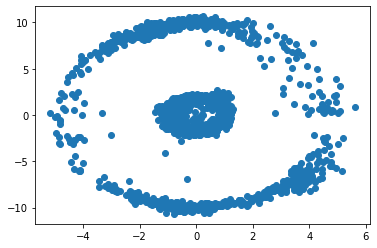

In [203]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

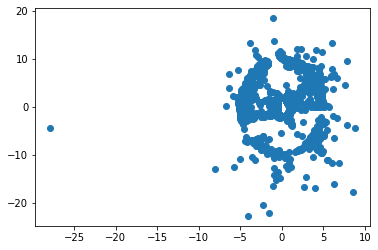

In [204]:
plt.scatter(ode_samples[:,0], ode_samples[:,1])

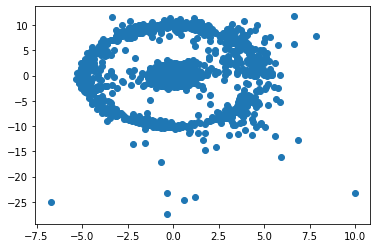

In [205]:
plt.scatter(sde_samples[:,0], sde_samples[:,1])

(-11.0, 11.0)

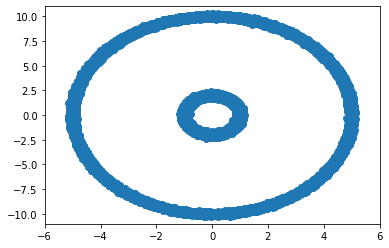

In [192]:
plt.scatter(circles[0], circles[1])
plt.xlim(-6,6)
plt.ylim(-11,11)

In [206]:
#Now trying with conditional dataset

In [17]:
y = -6 * torch.rand(50000) + 3
z = np.random.gamma(1,0.3, size = 50000)
x = np.tanh(y) + z
ex_1 = torch.vstack([x, y]).T

In [18]:
y = -6 * torch.rand(50000) + 3
z = np.random.normal(0,np.sqrt(0.05), size = 50000)
x = torch.tanh(y+z)
ex_2 = torch.vstack([x, y]).T

In [19]:
y = -6 * torch.rand(50000) + 3
z = np.random.gamma(1,0.3, size = 50000)
z = torch.tensor(z)
x = z*torch.tanh(y)
ex_3 = torch.vstack([x, y]).T

In [22]:
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ex_1_test.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-12-70275349fc81>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


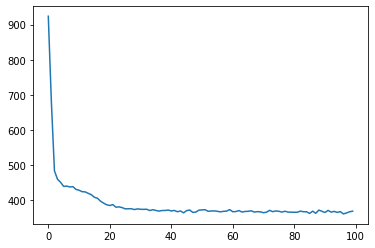

In [23]:
plt.plot(losses)

In [24]:
#@title Sampling (double click to expand or collapse)

## Load the pre-trained checkpoint from disk.

ckpt = torch.load('models/ex_1_test.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 2048 #@param {'type':'integer'}

#@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
## Generate samples using the specified sampler.
pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

ode_samples= ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)


sde_samples= Euler_Maruyama_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

<ipython-input-12-70275349fc81>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-12-70275349fc81>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
def density_plot(sample):
    df = pd.DataFrame(sample.numpy())
    df.columns =['x1', 'x2']
    sns.displot(df, x ='x1', y='x2', kind="kde")

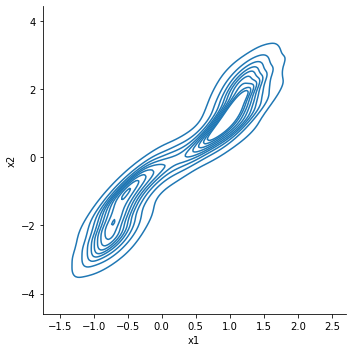

In [26]:
density_plot(pc_samples)

(-3.2, 3.2)

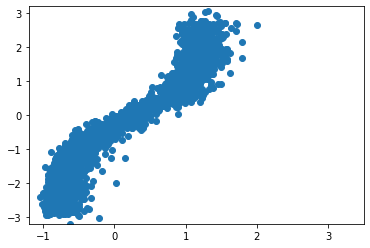

In [27]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

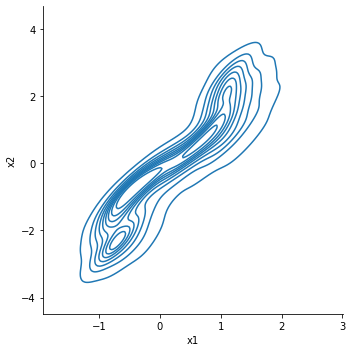

In [28]:
density_plot(ode_samples)

(-3.2, 3.2)

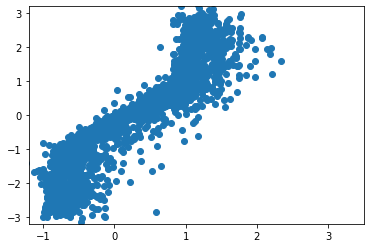

In [29]:
plt.scatter(ode_samples[:,0], ode_samples[:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

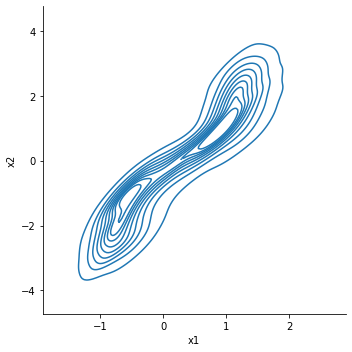

In [30]:
density_plot(sde_samples)

(-3.2, 3.2)

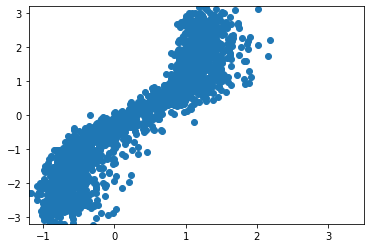

In [31]:
plt.scatter(sde_samples[:,0], sde_samples[:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

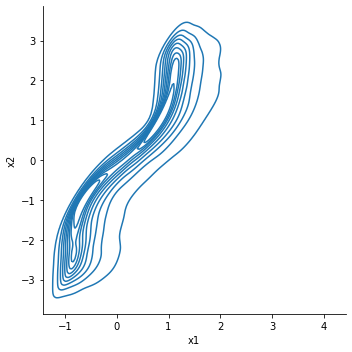

In [38]:
density_plot(ex_1)

In [33]:
indices = torch.randperm(len(ex_1))[:2048]

(-3.2, 3.2)

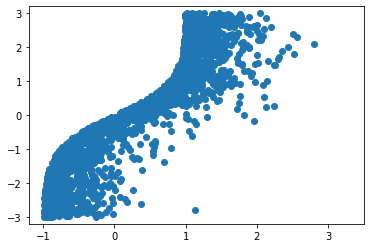

In [34]:
plt.scatter(ex_1[indices][:,0], ex_1[indices][:,1])
plt.xlim(-1.2, 3.5)
plt.ylim(-3.2,3.2)

In [35]:
#@title Define the likelihood function (double click to expand or collapse)

def prior_likelihood(z, sigma):
  """The likelihood of a Gaussian distribution with mean zero and 
      standard deviation sigma."""
  shape = z.shape
  N = np.prod(shape[1:])
  return -N / 2. * torch.log(2*np.pi*sigma**2) - torch.sum(z**2, dim=1) / (2 * sigma**2)

def ode_likelihood(x, 
                   score_model,
                   marginal_prob_std, 
                   diffusion_coeff,
                   batch_size=64, 
                   device='cpu',
                   eps=1e-5):
  """Compute the likelihood with probability flow ODE.
  
  Args:
    x: Input data.
    score_model: A PyTorch model representing the score-based model.
    marginal_prob_std: A function that gives the standard deviation of the 
      perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the 
      forward SDE.
    batch_size: The batch size. Equals to the leading dimension of `x`.
    device: 'cuda' for evaluation on GPUs, and 'cpu' for evaluation on CPUs.
    eps: A `float` number. The smallest time step for numerical stability.

  Returns:
    z: The latent code for `x`.
    bpd: The log-likelihoods in bits/dim.
  """

  # Draw the random Gaussian sample for Skilling-Hutchinson's estimator.
  epsilon = torch.randn_like(x)
      
  def divergence_eval(sample, time_steps, epsilon):      
    """Compute the divergence of the score-based model with Skilling-Hutchinson."""
    score_sample = torch.hstack([sample, time_steps])
    with torch.enable_grad():
      score_sample.requires_grad_(True)
      score_e = torch.sum(score_model(score_sample) * epsilon)
        
      grad_score_e = torch.autograd.grad(score_e, score_sample)[0]
    
    grad_score_e = grad_score_e[:,[0,1]]

    return torch.sum(grad_score_e * epsilon, dim=1)    
  
  shape = x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the score-based model for the black-box ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], 1))   
    sample = torch.hstack([sample, time_steps])
    with torch.no_grad():    
      score = score_model(sample)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def divergence_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the divergence of score for the black-box ODE solver."""
    with torch.no_grad():
      # Obtain x(t) by solving the probability flow ODE.
      sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
      time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], 1))    
      # Compute likelihood.
      div = divergence_eval(sample, time_steps, epsilon)
      return div.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):
    """The ODE function for the black-box solver."""
    time_steps = np.ones((shape[0],)) * t    
    sample = x[:-shape[0]]
    logp = x[-shape[0]:]
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    sample_grad = -0.5 * g**2 * score_eval_wrapper(sample, time_steps)
    logp_grad = -0.5 * g**2 * divergence_eval_wrapper(sample, time_steps)
    return np.concatenate([sample_grad, logp_grad], axis=0)

  init = np.concatenate([x.cpu().numpy().reshape((-1,)), np.zeros((shape[0],))], axis=0)
  # Black-box ODE solver
  res = integrate.solve_ivp(ode_func, (eps, 1.), init, rtol=1e-5, atol=1e-5, method='RK45')  
  zp = torch.tensor(res.y[:, -1], device=device)
  z = zp[:-shape[0]].reshape(shape)
  delta_logp = zp[-shape[0]:].reshape(shape[0])
  sigma_max = marginal_prob_std(1.)
  prior_logp = prior_likelihood(z, sigma_max)
  bpd = -(prior_logp + delta_logp) / np.log(2)
  N = np.prod(shape[1:])
  bpd = bpd / N + 8.
  return z, bpd

In [37]:
#@title Compute likelihood on the dataset (double click to expand or collapse)
#NOT SURE IF THIS IS WORKING

batch_size = 1000 #@param {'type':'integer'}

dataset = ex_1
data_loader = DataLoader(dataset, batch_size=batch_size)

ckpt = torch.load('models/ex_1_test.pth', map_location=device)
score_model.load_state_dict(ckpt)

all_bpds = 0.
all_items = 0
try:
  tqdm_data = notebook.tqdm(data_loader)
  for x in tqdm_data:
    x = x.to(device)
    # uniform dequantization
    #x = (x * 255. + torch.rand_like(x)) / 256.    
    _, bpd = ode_likelihood(x, score_model, marginal_prob_std_fn,
                            diffusion_coeff_fn,
                            x.shape[0], device=device, eps=1e-5)
    all_bpds += bpd.sum()
    all_items += bpd.shape[0]
    tqdm_data.set_description("Average bits/dim: {:5f}".format(all_bpds / all_items))

except KeyboardInterrupt:
  # Remove the error message when interuptted by keyboard or GUI.
  pass


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-12-70275349fc81>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
<ipython-input-12-70275349fc81>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


In [168]:
all_bpds / all_items
#is this unit applicable? bits/dim used for image likelihood. Doubt its the same for datapoints

tensor(9.2757, dtype=torch.float64)

In [38]:
#training ex_2
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ex_2_test.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-12-70275349fc81>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


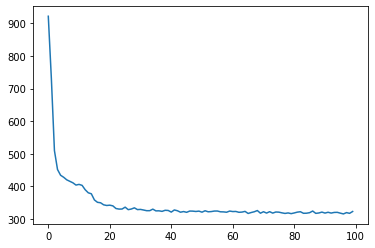

In [39]:
#323
plt.plot(losses)

In [40]:
## Load the pre-trained checkpoint from disk.
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('models/ex_2_test.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 2048 #@param {'type':'integer'}

#@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
## Generate samples using the specified sampler.
pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

ode_samples= ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

sde_samples= Euler_Maruyama_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

<ipython-input-12-70275349fc81>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-12-70275349fc81>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 218


  0%|          | 0/1000 [00:00<?, ?it/s]

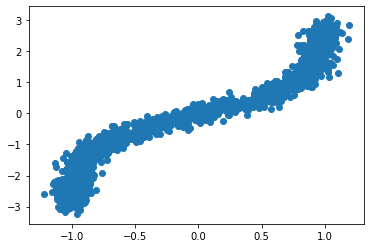

In [42]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

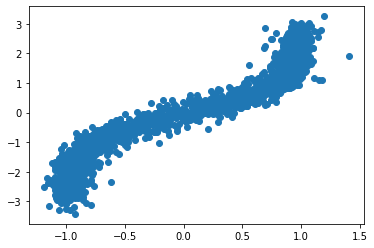

In [43]:
plt.scatter(ode_samples[:,0], ode_samples[:,1])

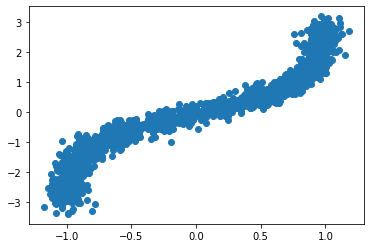

In [44]:
plt.scatter(sde_samples[:,0], sde_samples[:,1])

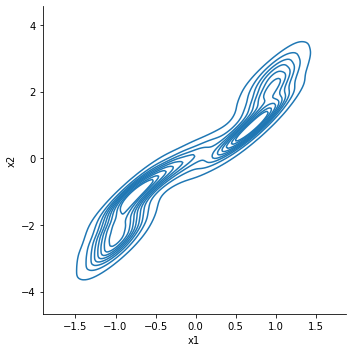

In [45]:
density_plot(pc_samples)

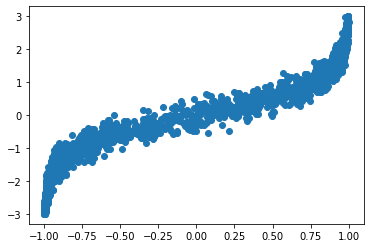

In [46]:
plt.scatter(ex_2[indices][:,0], ex_2[indices][:,1])

In [47]:
#training ex_3
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_3
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ex_3_test.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-12-70275349fc81>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


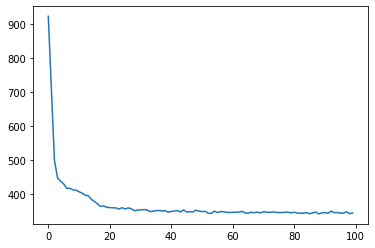

In [48]:
#351
plt.plot(losses)

In [49]:
## Load the pre-trained checkpoint from disk.
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('models/ex_3_test.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 2048 #@param {'type':'integer'}

#@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
## Generate samples using the specified sampler.
pc_samples= pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

ode_samples= ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)


sde_samples= Euler_Maruyama_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

<ipython-input-12-70275349fc81>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-12-70275349fc81>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 212


  0%|          | 0/1000 [00:00<?, ?it/s]

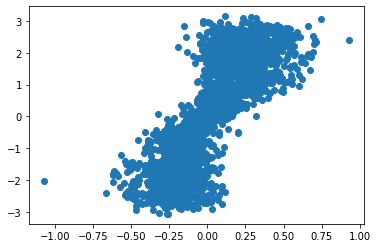

In [50]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

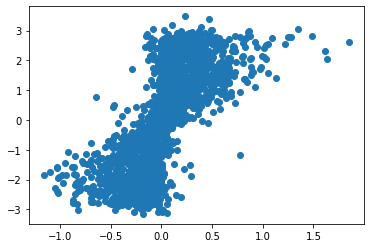

In [51]:
plt.scatter(ode_samples[:,0], ode_samples[:,1])

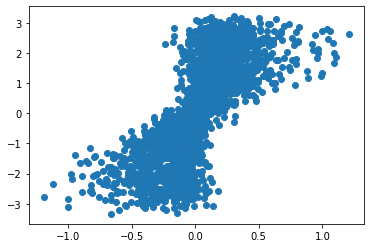

In [52]:
plt.scatter(sde_samples[:,0], sde_samples[:,1])

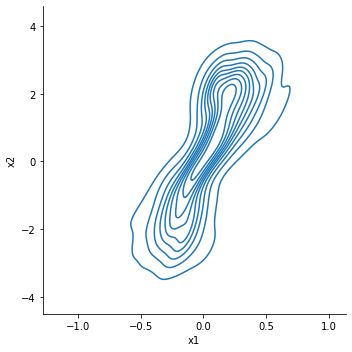

In [53]:
density_plot(pc_samples)

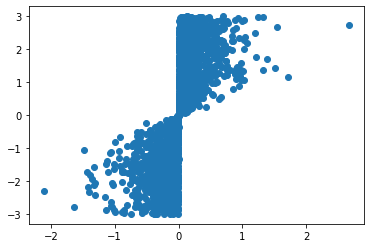

In [54]:
plt.scatter(ex_3[indices][:,0], ex_3[indices][:,1])